In [5]:
# loading libraries
import pandas as pd
import matplotlib.pyplot as plt
from numpy import arange

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, root_mean_squared_log_error

from FunctionsML import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

# Loading Data
- The data is from a Kaggle competition and contains 80 metrics describing housing prices
- The SalePrice is the target feature and should be forcast via a supervised Machine Learning
  Algorithm

In [7]:
df = pd.read_csv('Data/housing_iteration_6_regression.csv')
df.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1008,1009,20,RL,43.0,12118,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,1Story,7,5,2004,2005,Hip,CompShg,VinylSd,VinylSd,Stone,108.0,Gd,TA,PConc,Ex,TA,Mn,Unf,0,Unf,0,1710,1710,GasA,Ex,Y,SBrkr,1710,0,0,1710,0,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,Fin,2,550,TA,TA,Y,100,48,0,0,180,0,NaN,NaN,NaN,0,4,2009,WD,Normal,240000
678,679,20,RL,80.0,11844,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,464.0,Gd,TA,PConc,Ex,TA,Mn,Unf,0,Unf,0,2046,2046,GasA,Ex,Y,SBrkr,2046,0,0,2046,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2008.0,Fin,3,834,TA,TA,Y,322,82,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,Partial,372500
837,838,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,5,1973,1973,Gable,CompShg,HdBoard,HdBoard,BrkFace,158.0,TA,TA,CBlock,TA,TA,No,BLQ,330,Unf,0,153,483,GasA,TA,Y,SBrkr,483,504,0,987,1,0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1973.0,Unf,1,264,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal,100000
478,479,20,RL,79.0,10637,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2007,2008,Hip,CompShg,VinylSd,VinylSd,Stone,336.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1288,Unf,0,417,1705,GasA,Ex,Y,SBrkr,1718,0,0,1718,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,3,826,TA,TA,Y,208,44,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal,297000
510,511,20,RL,75.0,14559,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1951,2000,Hip,CompShg,Wd Sdng,Wd Sdng,BrkCmn,70.0,Gd,TA,CBlock,TA,TA,No,BLQ,650,Rec,180,178,1008,GasA,Ex,Y,SBrkr,1363,0,0,1363,1,0,1,0,2,1,TA,6,Min1,2,TA,CarPort,1951.0,Unf,1,288,TA,TA,Y,324,42,0,0,168,0,NaN,NaN,Shed,2000,6,2009,WD,Normal,164900


# Data Cleaning

In [9]:
# get rid of 10 strange entries in MSZoning
df.loc[df['MSZoning'] == 'C (all)','MSZoning'] = 'NA'

# Preprocessing

- First, a test train split is performed (**X_train, X_test, y_train, y_test**),
  20% of the data is used as test data to reduce and test overfitting
- Numerical and categorical features are split (**X_cat, X_num**)
- 1.1) Numerical Pipe
  - The numerical data is treated with a SimpleImputer to get rid of NaNs,
  if imputing the mean or median values is tested later, variable: **numeric_pipe**
- 1.2) Categorical Pipe
  - The ordinal categorical data is transformed with an ordinal encoder and
    the remaining data with an one-hot encoder, the whole tranformner is
    called **cat_encoder**
  - The categorical data is treated with a SimpleImputer as well
  - The cat_encoder and the SimpleImputer form the **categoric_pipe**
- 1.3) The numerical_pipe and the categoric_pipe form the **preprocessor**

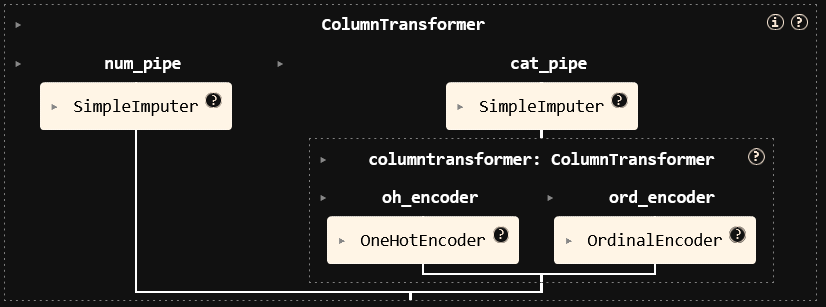
  
  

In [12]:
# seperate prediction- and target features
X = df.copy() # prediction features
X = X.set_index('Id') # the ID is used as index
y = X.pop('SalePrice') # target features

# perform the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1230)

# 1) built Preprocessor
# seperate categorical and numerical data
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 1.1) create a numerical pipeline, only with the SimpleImputer, the strategy is scanned later
numeric_pipe = make_pipeline(
                            SimpleImputer()
                            )

In [13]:
# 1.2) create categorical pipeline

# Setting up the ordinal encoder
set_config(transform_output='pandas')
# define ordinal features
ord_feat = ['ExterQual',
            'ExterCond',
            'MSZoning',  
            'LotShape',  
            'Utilities', 
            'LandSlope', 
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure', 
            'BsmtFinType1',
            'BsmtFinType2', 
            'HeatingQC',
            'CentralAir', 
            'KitchenQual',
            'FireplaceQu',
            'GarageFinish',
            'GarageQual',
            'GarageCond', 
            'PavedDrive',
            'PoolQC',
            'Fence']

# Create ordered categories of all features
# All orders must include the cat_imputer's fill_value so missing values can be encoded
ex_to_po = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']

# Category orders for each ordinal feature
ExterQual = ex_to_po
ExterCond = ex_to_po
MSZoning = ['FV','RL','RP','RH','RM','C','A', 'I', 'NA']
LotShape = ['IR3','IR2','IR1','Reg','NA']
Utilities = ['AllPub','NoSewr','NoSeWa','ELO','NA']
LandSlope = ['Sev','Mod','Gtl','NA']
BsmtQual = ex_to_po
BsmtCond = ex_to_po
BsmtExposure = ['Gd', 'Av', 'Mn', 'No', 'NA']     
BsmtFinType1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtFinType2 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
HeatingQC = ex_to_po
CentralAir = ['Y','N','NA']
KitchenQual = ex_to_po
FireplaceQu = ex_to_po
GarageFinish =['Fin','RFn','Unf','NA']
GarageQual = ex_to_po
GarageCond = ex_to_po
PavedDrive =['Y', 'P', 'N', 'NA']
PoolQC = ['Ex', 'Gd', 'TA', 'Fa', 'NA']
Fence = ['GdPrv','MnPrv','GdWo','MnWw','NA']

# List of all orders
category_orders = [ExterQual,
                   ExterCond,
                   MSZoning,  
                   LotShape, 
                   Utilities, 
                   LandSlope,  
                   BsmtQual,
                   BsmtCond,
                   BsmtExposure,
                   BsmtFinType1,
                   BsmtFinType2, 
                   HeatingQC,
                   CentralAir,
                   KitchenQual,
                   FireplaceQu,
                   GarageFinish,
                   GarageQual,
                   GarageCond, 
                   PavedDrive, 
                   PoolQC,
                   Fence]

# Initializing ordinal encoder
ord_encoder = OrdinalEncoder(categories=category_orders)


# Defining all remaining features to be treated with a one-hot encoder
oh_feat = list(set(X_cat)-set(ord_feat)) # one hot features

# Initializing one-hot encoder
oh_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', # min_frequency determined in grid
                           sparse_output=False) # must be false now that we've set_config to pandas

# form two branches, one for OneHot and one for the ordinal encoder
cat_encoder = ColumnTransformer(
    transformers=[
    ('oh_encoder', oh_encoder, oh_feat),
    ('ord_encoder', ord_encoder, ord_feat)
    ], verbose_feature_names_out=False) 

In [14]:
# add a simple imputer to the cat_encoder to form the full categoric pipeline
categoric_pipe = make_pipeline(
                SimpleImputer(fill_value="NA"),  # fill missing data with 'NA'
                cat_encoder
)

# preprocessor: form one branch for the numerical and one for the categorical data
preprocessor = ColumnTransformer(
    transformers=[
    ('num_pipe', numeric_pipe, X_num.columns),
    ('cat_pipe', categoric_pipe, X_cat.columns),
    ]
)

# Different Algorithms
- Regression performance is tested with different algorithms
  Decision tree, Random Forest
- The hyperparameter space is always tested with a 5-fold Cross Validation
  using GridSearchCV.  For scoring 'neg_root_mean_squared_log_error'
  is used, as this is the parameter scanned for in the Kaggle competition

## Decision tree
- Decision tree with the preprocessor

 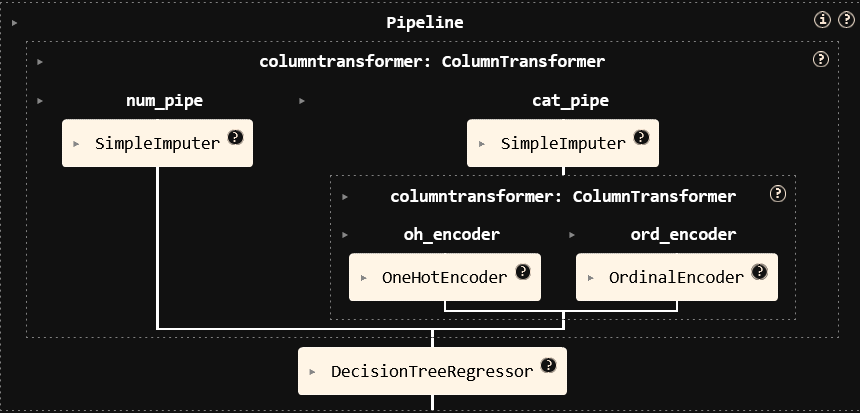

In [17]:
# creating a dataframe to save scores
scores=pd.DataFrame(columns=['R2','RSME','neg_root_mean_squared_log_error'])

In [18]:
# create full pipeline with the preprocessor and the decision tree
dt_pipe = make_pipeline(preprocessor,
                            DecisionTreeRegressor(random_state=123))


In [19]:
# Defining the cross validation
dt_param_grid = {
    'columntransformer__cat_pipe__simpleimputer__strategy':['constant','most_frequent'], 
    'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'], 
    'decisiontreeregressor__max_depth': range(13, 16, 1), 
    'decisiontreeregressor__min_samples_leaf': range(13,16,1), 
    'decisiontreeregressor__min_impurity_decrease':arange(0.1, 0.5, 0.1),  
    'decisiontreeregressor__ccp_alpha': [0] + [10**e for e in range(-7, -4)]
}

# Initalize the GridSearch
dt_search = GridSearchCV(dt_pipe, # you have defined this beforehand
                      dt_param_grid, # your parameter grid
                      cv=5, # the value for K in K-fold Cross Validation
                      scoring='neg_root_mean_squared_log_error', # the performance metric to use,
                      n_jobs=-1, # uses all CPU cores, slows down other applications
                      verbose=1) # controls output

# Fit your parameter grid to the training data, %time stops time
%time dt_search.fit(X_train, y_train)

# get score of training data for the best estimator
dt_score = get_scores(dt_search,X_train,y_train)
dt_score

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
CPU times: total: 19.7 s
Wall time: 43.4 s


{'neg_root_mean_squared_log_error': -0.144, 'R2': 0.857, 'RSME': 29710.598}

In [20]:
# get score of testing data for the best estimator
dt_test = get_scores(dt_search,X_test,y_test)
dt_test
# save scores of train and test into df
scores = final_scores(scores,dt_score,name='dt_train')
scores = final_scores(scores,dt_test,name='dt_test')
scores 

,neg_root_mean_squared_log_error,R2,RSME
dt_train,-0.144,0.857,29710.598
dt_test,-0.171,0.812,36045.833


## K nearest neighbours
* requires scaling
* highly sensitve to feature selection
* slow prediction, fast fitting
* Principal component analysis can be implemented into the pipeline

**The Pipeline**
<br>After the preprocessing different methods are tested:
- 'standardscaler': As the KNN regressor needs scaling, different scaling methods are tested,
  the standard and the robust scaler are found to be most promising
- 'feature': feature selection checks for import features and reduces the dimensionality
   of the dataset, different methods are probed:
    - SelectFromModel(DecisionTreeRegressor), which uses a Decision Tree for feature selection
    - SelectKBest(f_regression or mutual_info_regression), which uses statistical methods
       
- 'knn': the number of neighbors, the weights (uniform: all neighbours equal/distance, closer
  neighbours more important) and the measuring distances p (manhattan or Euclidean distance)
  are tested

To show the process of finding the right parameters, parameter grids of the most important steps
are left in the code 

In [22]:
knn_pipe= Pipeline([('preprocessor', preprocessor),
                    ('standardscaler', StandardScaler()),
                    ('feature', 'passthrough'), # for feature selection
                    ('knn', KNeighborsRegressor()),
])    

In [23]:
# this parameter grid is the result of hyperparameter tuning and a randomized Grid search

# with this param_grid, using pca, similar results are archived
# knn_param_grid = {
#     'preprocessor__cat_pipe__simpleimputer__strategy':['constant'], 
#     'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'],
#     'standardscaler': [StandardScaler()],   # best scaler for pca

#     'pca':[PCA()],       # no PCA or PCA
#     'pca__n_components': range(3, 6),                                  

#     'knn__n_neighbors': range(5, 8, 1),                  
#     'knn__weights': ['uniform'],     # distance results in overfitting directly          
#     'knn__p':range(1,2,1)                                
# }

# param_grid using SelectKBest
knn_param_grid = {
    'preprocessor__cat_pipe__simpleimputer__strategy':['constant','most_frequent'],
    'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'],
    'standardscaler': [RobustScaler()],   # best scaler for SelectKBest

    'feature':[SelectKBest()], 
    'feature__score_func': [mutual_info_regression], 
    'feature__k':range(26,32,2),   

    'knn__n_neighbors': range(6, 12, 1),  
    'knn__weights': ['uniform'],     # distance results in overfitting            
    'knn__p':range(1,2,1)                                
}                                                                 
# initialiing the Cross Validation
knn_search = GridSearchCV(knn_pipe,
                          knn_param_grid,
                          cv=5,
                          scoring='neg_root_mean_squared_log_error',
                          verbose=1,
                          n_jobs=-1)

%time knn_search.fit(X_train, y_train)

# get score of training data for the best estimator
knn_score = get_scores(knn_search,X_train,y_train)
knn_score

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 3.75 s
Wall time: 1min 14s


{'neg_root_mean_squared_log_error': -0.139, 'R2': 0.859, 'RSME': 29512.184}

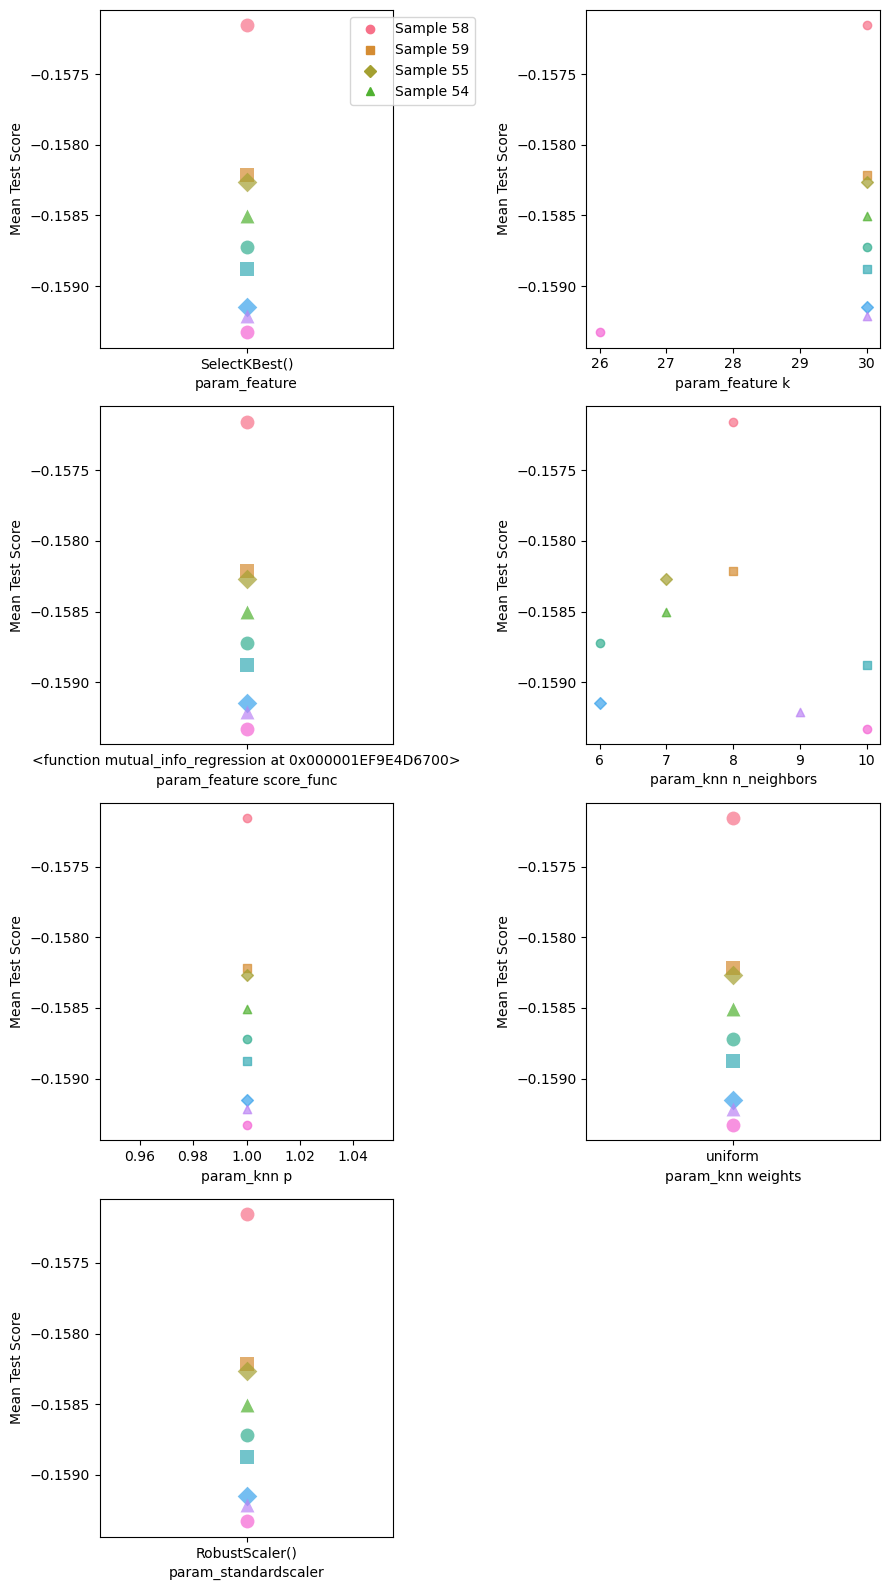

In [24]:
# show parameters of 10 best scores
param_plot(show_best(knn_search,10))

In [25]:
# get score of testing data for the best estimator
knn_test = get_scores(knn_search,X_test,y_test)
knn_test
# save scores of train and test into df
scores = final_scores(scores,knn_score,name='knn_train')
scores = final_scores(scores,knn_test,name='knn_test')
scores 

,neg_root_mean_squared_log_error,R2,RSME
dt_train,-0.144,0.857,29710.598
dt_test,-0.171,0.812,36045.833
knn_train,-0.139,0.859,29512.184
knn_test,-0.134,0.868,30192.463


## Random Forest
* tradeoff between performance vs training time (start with few fits)
* robust to overfitting
* no scaling needed
* Random forests benefit from feature selection but can still tolerate high numbers of features.
  Unlike KNN, features that only have a little information can still be utilized by random forests.

**The Pipeline**
<br>After the preprocessing different methods are tested:
- 'feature': feature selection checks for import features and reduces the dimensionality
   of the dataset, different methods are probed:
    - SelectFromModel(DecisionTreeRegressor), which uses a Decision Tree for feature selection
    - SelectKBest(f_regression or mutual_info_regression), which uses statistical methods
       
- 'rf': the number of neighbors, the weights (uniform: all neighbours equal/distance, closer
  neighbours more important) and the measuring distances p (manhattan or Euclidean distance)
  are tested

To show the process of finding the right parameters, parameter grids of the most important steps
are left in the code 

In [27]:
rf_pipe= Pipeline([('preprocessor',preprocessor),
                    ('feature', 'passthrough'), # for testing the feature selection
                    ('rf', RandomForestRegressor()),
])

In [28]:
# this parameter grid is the result of hyperparameter tuning and a randomized Grid search
rf_param_grid = {
    'preprocessor__cat_pipe__simpleimputer__strategy':['most_frequent'], # 'constant'
    'preprocessor__num_pipe__simpleimputer__strategy':['mean'], # 'median'
    # feature selection
    'feature':[SelectKBest()], 
    'feature__score_func': [mutual_info_regression], #f_regression,  
    'feature__k':[23,24],
    # rf
    'rf__n_estimators': [200, 210, 220],  
    'rf__max_depth': [11,12,13],        
    'rf__min_samples_leaf': [2,3],  
    'rf__ccp_alpha': [10**e for e in range(-3, -1)] +[0]    
} 

rf_search = GridSearchCV(rf_pipe,
                               rf_param_grid, 
                               cv = 5, 
                               scoring='neg_root_mean_squared_log_error',
                               verbose=1, 
                               n_jobs = -1)

%time rf_search.fit(X_train, y_train)

# get score of training data for the best estimator
rf_score = get_scores(rf_search,X_train,y_train)
rf_score

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: total: 6.84 s
Wall time: 3min 18s


{'neg_root_mean_squared_log_error': -0.078, 'R2': 0.966, 'RSME': 14402.899}

In [29]:
# get score of testing data for the best estimator
rf_test = get_scores(rf_search,X_test,y_test)
rf_test
# save scores of train and test into df
scores = final_scores(scores,rf_score,name='rf_train')
scores = final_scores(scores,rf_test,name='rf_test')
scores 

,neg_root_mean_squared_log_error,R2,RSME
dt_train,-0.144,0.857,29710.598
dt_test,-0.171,0.812,36045.833
knn_train,-0.139,0.859,29512.184
knn_test,-0.134,0.868,30192.463
rf_train,-0.078,0.966,14402.899
rf_test,-0.140,0.878,29014.540


## Comparing


In [51]:
scores['neg_root_mean_squared_log_error']

dt_train    -0.144
dt_test     -0.171
knn_train   -0.139
knn_test    -0.134
rf_train    -0.078
rf_test     -0.140
Name: neg_root_mean_squared_log_error, dtype: float64

- The decision tree was least tuned.
- best results are now yielded with the knn algorithm, only really small difference between train and testing data show good generalization of the algorithm.
- testing data of random forest shows no good generalization, as training data is much better

My results (red) score average in the competition, further optimizing especially with the RF<br>
algorithm is needed. I want to test the XG boost regresssor as well. 

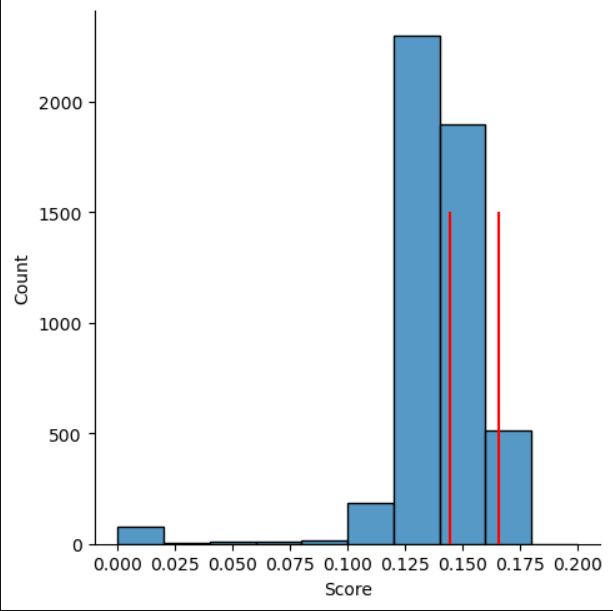